In [ ]:
!pip install transformers torch numpy openai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import os
import re
import uuid
import torch
import json

In [ ]:
directory_path = "/content/drive/MyDrive/documents"
os.makedirs(directory_path, exist_ok=True)

In [ ]:
def load_documents(directory_path):
    documents = {}  # Dictionary to store document ID and text content

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path):
            # Generate unique document ID
            doc_id = str(uuid.uuid4())

            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()

            documents[doc_id] = {"text": text, "metadata": {"file_name": filename}}

    return documents

# Load documents and print to check the content
documents = load_documents(directory_path)
print("Loaded Documents:", documents)

Loaded Documents: {'72e2f0ff-a1eb-4108-9ce1-579b9c27d533': {'text': 'SQuAD Samples for Title: Digestion\n==================================================\n\nSample 1\nID: 570be2d2ec8fbc190045bbbe\nQuestion: What is the first step in the human digestive system?\nContext: In the human digestive system, food enters the mouth and mechanical digestion of the food starts by the action of mastication (chewing), a form of mechanical digestion, and the wetting contact of saliva. Saliva, a liquid secreted by the salivary glands, contains salivary amylase, an enzyme which starts the digestion of starch in the food; the saliva also contains mucus, which lubricates the food, and hydrogen carbonate, which provides the ideal conditions of pH (alkaline) for amylase to work. After undergoing mastication and starch digestion, the food will be in the form of a small, round slurry mass called a bolus. It will then travel down the esophagus and into the stomach by the action of peristalsis. Gastric juice

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def chunk_text_with_semantic_cohesion(documents, model_name="bert-base-uncased", chunk_size=200):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    all_chunks = {}  # Dictionary to store all chunks with document and chunk IDs

    for doc_id, doc_data in documents.items():
        text = doc_data["text"]
        paragraphs = re.split("\n\n", text)  # Split text by paragraphs

        for paragraph in paragraphs:
            sentences = sent_tokenize(paragraph)  # Split paragraph into sentences using NLTK

            current_chunk = ""
            chunks = []

            # Iterate over sentences to create chunks
            for sentence in sentences:
                new_chunk = current_chunk + " " + sentence if current_chunk else sentence
                # Check if the chunk size exceeds the limit in tokens
                if len(tokenizer.tokenize(new_chunk)) <= chunk_size:
                    current_chunk = new_chunk
                else:
                    if current_chunk:  # If the current chunk is not empty, add it to chunks
                        chunks.append(current_chunk)
                    current_chunk = sentence  # Start a new chunk with the current sentence

            # Append the last chunk if it exists
            if current_chunk:
                chunks.append(current_chunk)

            # Assign a unique ID to each chunk
            for chunk_text in chunks:
                chunk_id = str(uuid.uuid4())
                all_chunks[chunk_id] = {
                    "text": chunk_text,
                    "metadata": {"doc_id": doc_id, "file_name": doc_data["metadata"]["file_name"]}
                }

    return all_chunks

# Apply chunking function to documents and print a sample to verify
all_chunks = chunk_text_with_semantic_cohesion(documents)
print("Sample Chunk:", list(all_chunks.items())[:1])  # Print a sample chunk to check

Sample Chunk: [('77fcd3b8-b6f5-4b18-9c9c-5d2f9d5141c7', {'text': 'SQuAD Samples for Title: Digestion\n==================================================', 'metadata': {'doc_id': '72e2f0ff-a1eb-4108-9ce1-579b9c27d533', 'file_name': 'squad_samples_Digestion.txt'}})]


In [ ]:
import numpy as np
import torch

def generate_embeddings(data, model, tokenizer):
    embeddings = {}

    for chunk_id, chunk_data in data.items():
        # Tokenize the text
        inputs = tokenizer(chunk_data["text"], return_tensors="pt", padding=True, truncation=True)

        # Generate embeddings
        with torch.no_grad():
            output = model(**inputs)
            # Assuming we want the mean of the last hidden state
            embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()  # Convert to numpy array

        embeddings[chunk_id] = {
            "embedding": embedding,
            "metadata": chunk_data["metadata"],
            "text": chunk_data["text"]  # Store the original text if needed
        }

    return embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import matplotlib.pyplot as plt
import gensim.downloader as api

In [ ]:
# Dimensionality Reduction
def reduce_dimensionality(embeddings, n_components=2, method="pca"):
    all_embeddings = np.array([embedding["embedding"] for embedding in embeddings.values()])
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
    reduced_embeddings = reducer.fit_transform(all_embeddings)
    return reduced_embeddings

In [ ]:
# Visualization Function
def visualize_embeddings(reduced_embeddings, title):
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [ ]:
# Word2Vec Embeddings
word2vec_model = api.load("fasttext-wiki-news-subwords-300")

def get_word2vec_embedding(text):
    tokens = text.split()
    embeddings = np.zeros(300)
    count = 0
    for word in tokens:
        if word in word2vec_model:
            embeddings += word2vec_model[word]
            count += 1
    return embeddings / count if count > 0 else embeddings

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# GloVe Embeddings
glove_model = api.load("glove-wiki-gigaword-100")
def get_glove_embedding(text):
    tokens = text.split()
    embeddings = np.zeros(100)
    count = 0
    for word in tokens:
        if word in glove_model:
            embeddings += glove_model[word]
            count += 1
    return embeddings / count if count > 0 else embeddings

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Generate embeddings for all chunks and print a sample to verify
model_name = 'bert-base-uncased'  # Example model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
embeddings = generate_embeddings(all_chunks, model, tokenizer)

print("Embedding Shape:", embeddings[list(embeddings.keys())[0]]['embedding'].shape)

Embedding Shape: (768,)


In [ ]:
import json

def save_json(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

# Prepare documents and their embeddings for saving
documents = {}  # To store text chunks
mapped_document_db = {}  # To store embeddings

# Populate the dictionaries
for chunk_id, chunk_data in all_chunks.items():  # Iterate through your chunks
    text = chunk_data['text']  # Assuming each chunk has a 'text' key
    embedding = embeddings[chunk_id]['embedding'].tolist()  # Convert to list if necessary

    # Populate documents with text
    documents[chunk_id] = text

    # Populate the vector store with embeddings
    mapped_document_db[chunk_id] = embedding

# Save the documents and vector store to JSON files
save_json('doc_store.json', documents)
save_json('vector_store.json', mapped_document_db)

print("Document and vector stores saved to JSON files.")

Document and vector stores saved to JSON files.


In [ ]:
# Print the structure of the embeddings to check for keys
for chunk_id, chunk_data in embeddings.items():
    print(f"Chunk ID: {chunk_id}")
    print(f"Embedding Shape: {chunk_data['embedding'].shape}")  # Shape of the embedding
    print(f"Metadata: {chunk_data['metadata']}")
    print(f"Text: {chunk_data['text']}\n")  # Print the text if available

Chunk ID: 191f775a-131f-4e62-9581-82229fec0e5c
Embedding Shape: (768,)
Metadata: {'doc_id': '43c154d5-c03a-476b-a985-7c651a8a8286', 'file_name': 'squad_samples_Digestion.txt'}
Text: SQuAD Samples for Title: Digestion

Chunk ID: c296b9a8-35d7-40d6-be73-6857e6a5c50a
Embedding Shape: (768,)
Metadata: {'doc_id': '43c154d5-c03a-476b-a985-7c651a8a8286', 'file_name': 'squad_samples_Digestion.txt'}
Text: Sample 1
ID: 570be2d2ec8fbc190045bbbe
Question: What is the first step in the human digestive system? Context: In the human digestive system, food enters the mouth and mechanical digestion of the food starts by the action of mastication (chewing), a form of mechanical digestion, and the wetting contact of saliva. Saliva, a liquid secreted by the salivary glands, contains salivary amylase, an enzyme which starts the digestion of starch in the food; the saliva also contains mucus, which lubricates the food, and hydrogen carbonate, which provides the ideal conditions of pH (alkaline) for amylase 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_k(query_embedding, embeddings, k=5):
    # Calculate cosine similarity between the query and chunk embeddings
    similarities = {}
    for chunk_id, chunk_data in embeddings.items():
        similarity = cosine_similarity([query_embedding], [chunk_data['embedding']])[0][0]
        similarities[chunk_id] = similarity

    # Sort by similarity and return top k results
    top_k = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:k]
    return top_k

In [ ]:
# Example query text
query = "What is the name of the last residential area built by the British Raj in Delhi?"

# Tokenize and generate the query embedding
query_inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    query_embeddings = model(**query_inputs).last_hidden_state.mean(dim=1).squeeze()  # Get mean of last hidden state
query_embeddings = query_embeddings.numpy()  # Convert to numpy array
normalized_query = query_embeddings / np.linalg.norm(query_embeddings)  # Normalize the query embedding

In [ ]:
# Retrieve the top K results using the normalized query embedding
top_k_results = retrieve_top_k(normalized_query, embeddings, k=5)

# Print the top K results
print("Top K Retrieved Results:")
for chunk_id, similarity in top_k_results:
    chunk_text = embeddings[chunk_id]["text"]  # Access the text of the chunk
    metadata = embeddings[chunk_id]["metadata"]
    print(f"Chunk ID: {chunk_id}, Similarity: {similarity:.4f}, File: {metadata['file_name']}, Text: {chunk_text}")


Top K Retrieved Results:
Chunk ID: 814543e7-12b4-4180-a98f-4d0e81eb6f14, Similarity: 0.8332, File: squad_samples_New_Delhi.txt, Text: Sample 99
ID: 5705e82775f01819005e7741
Question: What was the name of the last residential area built by the British Raj? Context: After the capital of India moved to Delhi, a temporary secretariat building was constructed in a few months in 1912 in North Delhi. Most of the government offices of the new capital moved here from the 'Old secretariat' in Old Delhi (the building now houses the Delhi Legislative Assembly), a decade before the new capital was inaugurated in 1931. Many employees were brought into the new capital from distant parts of India, including the Bengal Presidency and Madras Presidency. Subsequently housing for them was developed around Gole Market area in the 1920s. Built in the 1940s, to house government employees, with bungalows for senior officials in the nearby Lodhi Estate area, Lodhi colony near historic Lodhi Gardens, was the la

In [ ]:
import openai
from transformers import pipeline

# Assuming `top_k_results` and `documents` are defined previously
first_match = top_k_results[0]  # You can choose a different match if needed
chunk_id = first_match[0]  # Chunk ID of the most similar document
relevant_text = documents[chunk_id]

# Load the GPT-2 model
generator = pipeline('text-generation', model='gpt2', device=0, pad_token_id=50256)

def generate_llm_response(query, relevant_text):
    try:
        # Construct the prompt with both relevant text and the query
        prompt = f"Given the following relevant information: {relevant_text}\n\nQuestion: {query}\nAnswer:"

        # Generate text with a bit more room for the response
        response = generator(prompt, max_new_tokens=100, num_return_sequences=1, truncation=True)

        # Extract the answer from the generated text
        generated_text = response[0]['generated_text'].strip()

        # Assuming the answer is the text after the "Answer:" label
        answer = generated_text.split('Answer:')[1].strip() if 'Answer:' in generated_text else generated_text
        return answer

    except Exception as e:
        print(f"Error generating response: {e}")
        return None

response = generate_llm_response(query, relevant_text)
print("Generated Response:", response)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generated Response: The last residential area built by the British Raj in Delhi was built in 1928, at which time the New Delhi government transferred possession of land for its city administration into the private hands of an Indian businessman. Thereafter, the private property was allotted as the "Home Office Zone", as the "Todas" was subsequently referred to as. The public land was given by the British Raj to the private owners in the Todas.

The Government of Delhi (and New Delhi's government in


##Embedding Generation and Indexing

In [ ]:
import re
import uuid
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import gensim.downloader as api
import json

# Step 1: Chunk Text with Semantic Cohesion
def chunk_text_with_semantic_cohesion(documents, model_name="bert-base-uncased", chunk_size=200):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    all_chunks = {}

    for doc_id, doc_data in documents.items():
        text = doc_data["text"]
        paragraphs = re.split("\n\n", text)

        for paragraph in paragraphs:
            sentences = sent_tokenize(paragraph)

            current_chunk = ""
            chunks = []
            for sentence in sentences:
                new_chunk = current_chunk + " " + sentence if current_chunk else sentence
                if len(tokenizer.tokenize(new_chunk)) <= chunk_size:
                    current_chunk = new_chunk
                else:
                    if current_chunk:
                        chunks.append(current_chunk)
                    current_chunk = sentence

            if current_chunk:
                chunks.append(current_chunk)

            for chunk_text in chunks:
                chunk_id = str(uuid.uuid4())
                all_chunks[chunk_id] = {
                    "text": chunk_text,
                    "metadata": {"doc_id": doc_id, "file_name": doc_data["metadata"]["file_name"]}
                }
    return all_chunks

# Step 2: Generate Embeddings
def generate_embeddings(data, model, tokenizer):
    embeddings = {}
    for chunk_id, chunk_data in data.items():
        inputs = tokenizer(chunk_data["text"], return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**inputs)
            embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings[chunk_id] = {
            "embedding": embedding,
            "metadata": chunk_data["metadata"],
            "text": chunk_data["text"]
        }
    return embeddings

# Step 3: Dimensionality Reduction
def reduce_dimensionality(embeddings, n_components=2, method="pca"):
    all_embeddings = np.array([embedding["embedding"] for embedding in embeddings.values()])
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
    reduced_embeddings = reducer.fit_transform(all_embeddings)
    return reduced_embeddings

# Visualization Function
def visualize_embeddings(reduced_embeddings, title):
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Step 4: Word2Vec Embeddings
word2vec_model = api.load("word2vec-google-news-300")
def get_word2vec_embedding(text):
    tokens = text.split()
    embeddings = np.zeros(300)
    count = 0
    for word in tokens:
        if word in word2vec_model:
            embeddings += word2vec_model[word]
            count += 1
    return embeddings / count if count > 0 else embeddings

# Step 5: GloVe Embeddings
glove_model = api.load("glove-wiki-gigaword-100")
def get_glove_embedding(text):
    tokens = text.split()
    embeddings = np.zeros(100)
    count = 0
    for word in tokens:
        if word in glove_model:
            embeddings += glove_model[word]
            count += 1
    return embeddings / count if count > 0 else embeddings

# Step 6: Save Embeddings
def save_json(file_path, data):
    # Convert numpy arrays to lists before saving
    modified_data = {}
    for key, value in data.items():
        modified_data[key] = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in value.items()}

    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(modified_data, f, indent=4, ensure_ascii=False)

# Step 7: Retrieve Top-K Chunks
def retrieve_top_k(query_embedding, embeddings, k=5):
    similarities = {}
    for chunk_id, chunk_data in embeddings.items():
        similarity = cosine_similarity([query_embedding], [chunk_data['embedding']])[0][0]
        similarities[chunk_id] = similarity
    top_k = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:k]
    return top_k

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def save_json(file_path, data):
    # Convert numpy arrays to lists before saving
    modified_data = {}
    for key, value in data.items():
        modified_data[key] = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in value.items()}

    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(modified_data, f, indent=4, ensure_ascii=False)

Sample Chunk: [('29e0f91a-bd0f-43de-8cf2-3f36332f270c', {'text': 'SQuAD Samples for Title: Digestion\n==================================================', 'metadata': {'doc_id': '72e2f0ff-a1eb-4108-9ce1-579b9c27d533', 'file_name': 'squad_samples_Digestion.txt'}})]


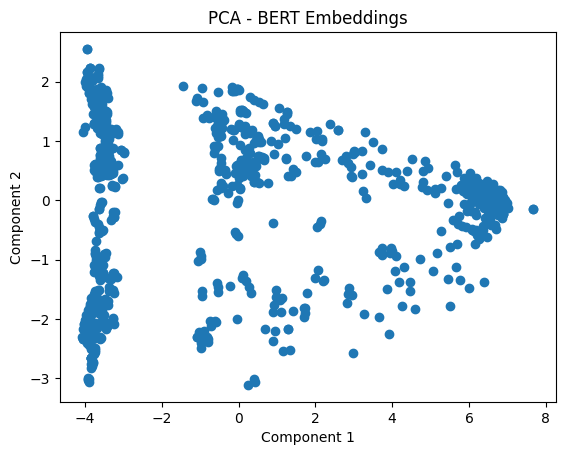

Top K Retrieved Results: [('347d1eae-77ee-4edb-9d4c-c9e19f3a3974', 0.83319247), ('0abff867-305d-4f29-be75-ac6eff6a7c60', 0.81073856), ('3fefd125-ef92-403c-956c-94624e858814', 0.77893), ('b05cc92d-d07d-4d10-80cf-b04326573df6', 0.7645205), ('a90261ec-639e-4a8f-9892-978aa2fff0d0', 0.7584939)]


In [ ]:
# Main Pipeline
if __name__ == "__main__":
    # Chunking
    all_chunks = chunk_text_with_semantic_cohesion(documents)
    print("Sample Chunk:", list(all_chunks.items())[:1])

    # Generate BERT Embeddings
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    bert_embeddings = generate_embeddings(all_chunks, model, tokenizer)

    # Dimensionality Reduction for BERT
    reduced_embeddings_pca = reduce_dimensionality(bert_embeddings, method="pca")
    visualize_embeddings(reduced_embeddings_pca, "PCA - BERT Embeddings")

    # Word2Vec Embeddings
    word2vec_embeddings = {chunk_id: {"embedding": get_word2vec_embedding(chunk_data["text"])} for chunk_id, chunk_data in all_chunks.items()}

    # GloVe Embeddings
    glove_embeddings = {chunk_id: {"embedding": get_glove_embedding(chunk_data["text"])} for chunk_id, chunk_data in all_chunks.items()}

    # Save to JSON
    save_json("bert_embeddings.json", bert_embeddings)
    save_json("word2vec_embeddings.json", word2vec_embeddings)
    save_json("glove_embeddings.json", glove_embeddings)

    # Retrieve Top-K
    query = "What is the name of the last residential area built by the British Raj in Delhi?"
    query_inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        query_embedding = model(**query_inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    top_k_results = retrieve_top_k(query_embedding, bert_embeddings, k=5)
    print("Top K Retrieved Results:", top_k_results)

In [ ]:
# Tokenize and generate the query embedding
query_inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    query_embeddings = model(**query_inputs).last_hidden_state.mean(dim=1).squeeze()  # Get mean of last hidden state
query_embeddings = query_embeddings.numpy()  # Convert to numpy array
normalized_query = query_embeddings / np.linalg.norm(query_embeddings)  # Normalize the query embedding

# Retrieve the top K results using the normalized query embedding
top_k_results = retrieve_top_k(normalized_query, embeddings, k=5)

# Print the top K results
print("Top K Retrieved Results:")
for chunk_id, similarity in top_k_results:
    chunk_text = embeddings[chunk_id]["text"]  # Access the text of the chunk
    metadata = embeddings[chunk_id]["metadata"]
    print(f"Chunk ID: {chunk_id}, Similarity: {similarity:.4f}, File: {metadata['file_name']}, Text: {chunk_text[:200]}...")


Top K Retrieved Results:
Chunk ID: 2066a683-963e-4b46-bf21-909ee8f59ea8, Similarity: 0.8332, File: squad_samples_New_Delhi.txt, Text: Sample 99
ID: 5705e82775f01819005e7741
Question: What was the name of the last residential area built by the British Raj? Context: After the capital of India moved to Delhi, a temporary secretariat bu...
Chunk ID: 2bb69ad1-f361-476b-a381-4f6c79d61581, Similarity: 0.8107, File: squad_samples_New_Delhi.txt, Text: Sample 57
ID: 5705e82775f01819005e773e
Question: A temporary secretariat building was built in New Delhi in what year? Context: After the capital of India moved to Delhi, a temporary secretariat build...
Chunk ID: 5dfadb3f-c554-4085-bffa-0505d5caeab1, Similarity: 0.7789, File: squad_samples_New_Delhi.txt, Text: Sample 18
ID: 5705e72075f01819005e772c
Question: The Imperial Delhi Railway was built to transport workers and materials for how many years? Context: In the south, land up to Safdarjung's Tomb was acq...
Chunk ID: 3ba7c8b2-03dc-4e65-8036-e8

In [ ]:
import openai
from transformers import pipeline

# Load the GPT-2 text-generation model
generator = pipeline('text-generation', model='gpt2', device=0, pad_token_id=50256)

def generate_llm_response(query, relevant_text):
    """
    Generate a response to a query using a language model and relevant document text.

    Parameters:
        query (str): The user query.
        relevant_text (str): The most relevant chunk of text retrieved.

    Returns:
        str: The generated response.
    """
    try:
        # Construct the prompt with both relevant text and the query
        prompt = f"Given the following relevant information: {relevant_text}\n\nQuestion: {query}\nAnswer:"

        # Generate text with GPT-2
        response = generator(prompt, max_new_tokens=100, num_return_sequences=1, truncation=True)

        # Extract the answer from the generated text
        generated_text = response[0]['generated_text'].strip()

        # Parse the generated response to extract the "Answer" part
        answer = generated_text.split('Answer:')[1].strip() if 'Answer:' in generated_text else generated_text
        return answer

    except Exception as e:
        print(f"Error generating response: {e}")
        return None

# Assuming `top_k_results` and `documents` are defined
# Retrieve the most relevant chunk's text
first_match = top_k_results[0]  # First result is assumed most relevant
chunk_id = first_match[0]  # Chunk ID of the most similar document
relevant_text = embeddings[chunk_id]["text"]  # Access the text using embeddings dictionary

# Generate and display a response to the query
response = generate_llm_response(query, relevant_text)
print("Generated Response:", response)


Generated Response: The name of the last residential area built by the British Raj is the name of the 'Brahmanapath' of the Bajrang Dal political party in Delhi. Today a private office of the Bajrang Dal is situated in the main office of the government of India. It is the only residential building that has been converted into an office building - the office building - by the British Raj. The building was the work of the Bajrang Dal, one of the key organisations fighting the
